## Graph Theory Approach to Portfolio Optimization
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4602019
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4667426

In [2]:
import numpy as np
import pandas as pd
# import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from scipy.optimize import minimize
import cvxpy as cp

"""
Libraries: 
networkx --> network science library
cvxpy --> convex optimization library
"""

'\nLibraries: \nnetworkx --> network science library\ncvxpy --> convex optimization library\n'

## Initializing data

In [3]:
snp500_symbols = pd.read_csv('../data/SP500.csv')['Symbol'].to_list()

In [90]:
# price_data = yf.download(snp500_symbols, start='2023-01-01',end='2024-12-30')['Close']
# price_data.to_csv('../data/price.csv')
price_data = pd.read_csv('../data/price.csv')
price_data = price_data.set_index('Date')
price_data = price_data.dropna(axis=1)


in_sample, out_sample = price_data.iloc[:price_data.shape[0]//5*4], price_data.iloc[price_data.shape[0]//5*4:]

"""
We use abs(r) as the similarity measure between stocks (so the lower the less correlated which we want).
"""

correlation_matrix = np.abs(in_sample.pct_change().dropna().corr())
# distance = 1-np.abs(correlation_matrix)
covariance_matrix = in_sample.pct_change().dropna().cov()
returns = np.log(in_sample.dropna().iloc[-1]) - np.log(in_sample.dropna().iloc[0])

out_of_sample_returns = np.log(out_sample.dropna().iloc[-1])-np.log(price_data.dropna().iloc[0])
out_of_sample_covariance_matrix = out_sample.pct_change().dropna().cov()

## Correlation Matrix of available stocks

<Axes: >

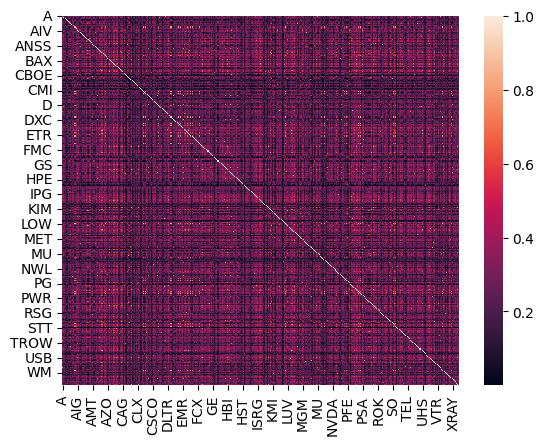

In [59]:
sns.heatmap(correlation_matrix)

## Constructing the graph (Networkx)

In [60]:
labels = list(correlation_matrix.columns)
print(labels)
print(len(labels))

['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMD', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BHF', 'BIIB', 'BK', 'BLK', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CCI', 'CCL', 'CDNS', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CVS', 'CVX', 'D', 'DAL', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 

In [61]:
# Function to return a networkx graph
def initialize_graph(labels, weights):
    G = nx.Graph()
    G.add_nodes_from(labels)
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            u, v = labels[i], labels[j]
            weight = weights.loc[u, v]
            if weight != 0:
                G.add_edge(u, v, weight=weight)
    return G

In [62]:
G = initialize_graph(labels,correlation_matrix)

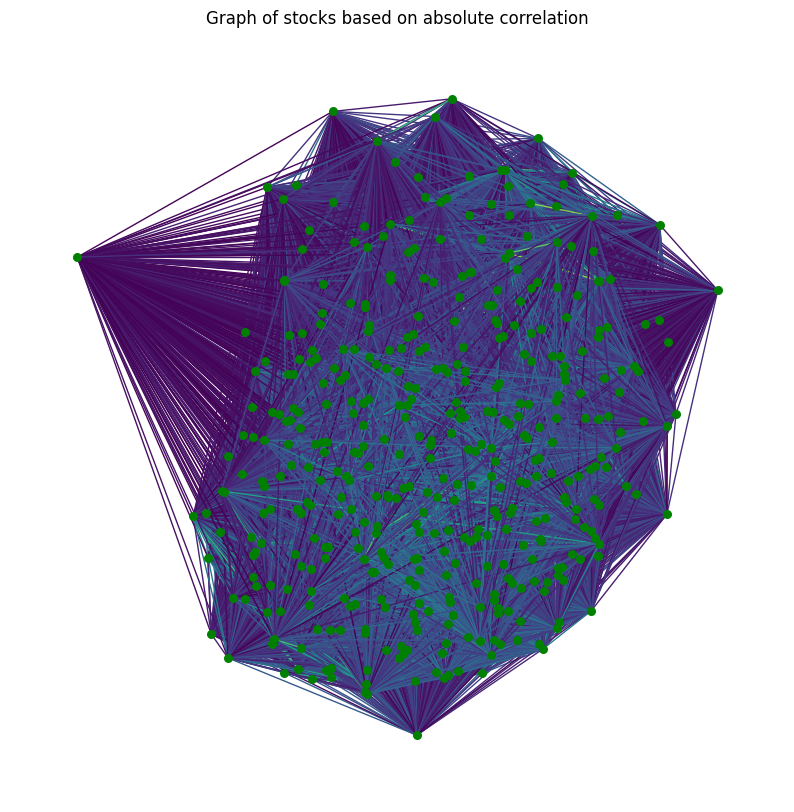

In [63]:
"""
Plot of the fully connected graph
"""
fig,ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(G, seed=42)
edge_weights = [d['weight'] for (_, _, d) in G.edges(data=True)]

nx.draw(
    G, 
    pos, 
    node_color='green', 
    edge_color=edge_weights, 
    width=1, 
    node_size=30, 
    edge_cmap=plt.cm.viridis
)
plt.title('Graph of stocks based on absolute correlation')
plt.show()


## Creating an MST and TMFG

In [64]:
"""
We use the abs(correlation) as our weights.
This way we get the least correlated stocks.

Default MST Algorithm from networkx
"""

mst = nx.minimum_spanning_tree(G, weight='weight')
mst_weights = nx.to_numpy_array(mst, weight='weight')

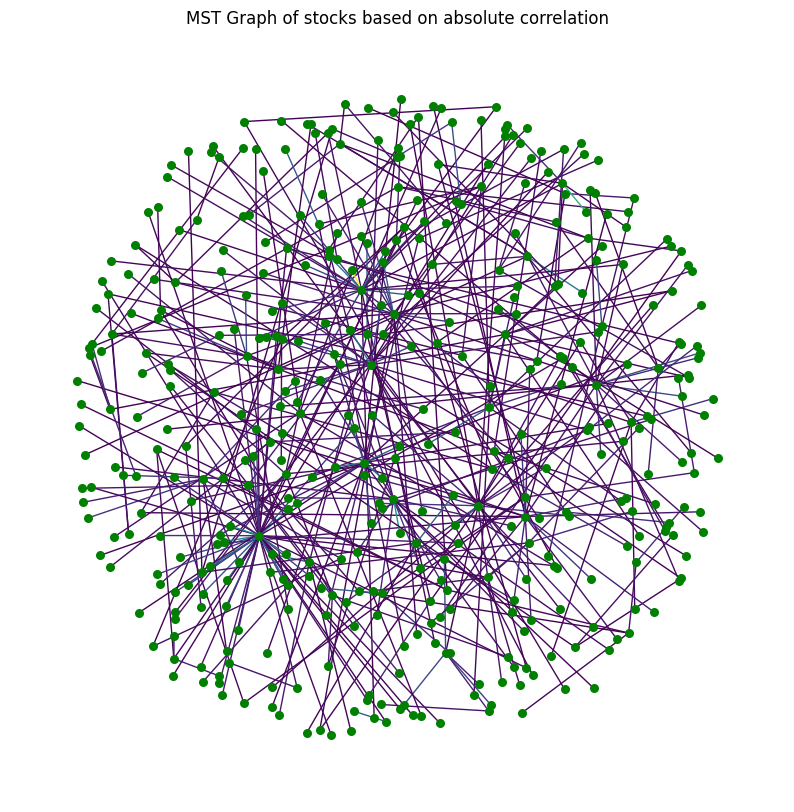

In [65]:
"""
Plot of MST
"""
fig,ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(mst, seed=42)
edge_weights = [d['weight'] for (_, _, d) in mst.edges(data=True)]

nx.draw(
    mst, 
    pos, 
    node_color='green', 
    edge_color=edge_weights, 
    width=1, 
    node_size=30, 
    edge_cmap=plt.cm.viridis
)
plt.title('MST Graph of stocks based on absolute correlation')
plt.show()

In [66]:
def tmfg_algorithm(weight_matrix):
    """
    Triangulated Maximally Filtered Graph:
    - Original Paper for the algorithm : https://doi.org/10.48550/arXiv.1505.02445

    For the TMFG algorithm, we have score function S: G -> R that takes 
    in graph info and outputs a real number, e.g. sum of edge weights.
    
    Starting from a completed weighted graph, we choose the highest scoring 4-clique.
    The 4 clique is now our current graph.
    Then we start a while loop where at every iteration:
    - We update a "cache" variable to calculate, w.r.t all triangular faces (triplets of vertices that are fully connected with each other) 
    in our current graph, the maximum possible score you could get by performing T_2 described in the paper 
    (inserting a new vertex at the center of said face and connecting it with edges to all the other vertices in the face). We also store the
    vertex corresponding to this.
    - Using the cache we just calculated, we insert the vertex + edges to the corresponding face that would give us the best score gain.
    - We repeat this until the list of vertices not present in our graph is empty.
    
    The output is our TMFG
    """
    
    ###
    """
    Finding best 4-clique.
    
    Problem setup:
    min {sum (w_{ij}*x_i*x_j), i<j} 
    s.t. 
    x_i in {0,1} for all i in V
    sum(x_i) = 4
    
    Since we have a large number of stocks (423) under consideration we find an approximate solution.
    
    Greedy Approach:
    - Find the vertex with the highest weight when considering all its edges.
    - From that vertex, iteratively go through all vertices, then add the vertex that gives the max weight gain
    - Repeat until we have 4 vertices.
    
    --> We use a "distance" measure = 1-abs(corr) so that less correlated stocks have higher distance, and have a higher score.
    """
    n = weight_matrix.shape[0]
    
    max_vert = None
    max_idx = 0
    max_weight = 0
    for i in range(n):
        total_weight = 0
        row = weight_matrix[i]
        for j in range(n):
            if j != i:
                total_weight += row[j]
        if total_weight>max_weight:
            max_weight = total_weight
            max_vert = labels[i]
            max_idx = i
    
    clique = [max_vert]
    clique_idx = [max_idx]
    while len(clique) != 4:
        max_vert = None
        max_idx = 0
        max_weight = 0
        for i in range(n):
            if i not in clique_idx:
                total_weight = 0
                row = weight_matrix[i]
                for j in clique_idx:
                    total_weight += row[j]
            
                if total_weight > max_weight:
                    max_weight = total_weight
                    max_vert = labels[i]
                    max_idx = i
        clique.append(max_vert)
        clique_idx.append(max_idx)   
    
    # Variables
    tmfg_vertices = [vert for vert in clique]
    tmfg_idx = [idx for idx in clique_idx]
    
    # Intialize an empty weight matrix for our tmfg, then add the info from our current 4-clique.
    tmfg_weights = np.zeros_like(weight_matrix)
    for i in tmfg_idx:
        for j in tmfg_idx:
            tmfg_weights[i,j] = weight_matrix[i,j]
    
    # Cache for storing the running best gains and best vertices, which are indexed by triangular faces, i.e. sets (v1,v2,v3).
    cache = {"best_gain" : dict() , "best_vertex" : dict()}
    
    # Store triangles
    current_triangles = [*combinations(tmfg_idx,3)]
    
    # Function to compute best gain
    def get_best_gain(triangle):
        best_idx = 0
        max_weight = 0
        for i in range(n):
            if i not in tmfg_idx:
                total_weight = 0
                for j in triangle:
                    total_weight += weight_matrix[i][j]
                if total_weight > max_weight:
                    max_weight = total_weight
                    best_idx = i
        return max_weight, best_idx
        
    ### Main TMFG Algorithm
    while len(tmfg_vertices) != n:
        # Reset Cache
        cache = {"best_gain" : dict() , "best_vertex" : dict()}
        
        # Calculating cache
        for t in current_triangles:
            score, idx = get_best_gain(t)
            cache['best_gain'][t] = score
            cache['best_vertex'][t] = idx
        
        # Find best gain and corresponding triangle and vertex to add
        highest_score = 0
        best_triangle = None
        best_vertex = None
        for t,score in cache['best_gain'].items():
            if score > highest_score:
                highest_score = score
                best_triangle = t
                best_vertex = cache['best_vertex'][t]
        
        # Add best vertex to tmfg (T2 operation)
        tmfg_idx.append(best_vertex)
        tmfg_vertices.append(labels[best_vertex])
        
        # Update tmfg weight matrix
        for i in best_triangle:
            tmfg_weights[i,best_vertex] = weight_matrix[i,best_vertex]
            tmfg_weights[best_vertex,i] = weight_matrix[best_vertex,i]
               
        # Update triangles
        current_triangles = [t for t in current_triangles if t != best_triangle]
        for i,j in combinations(best_triangle,2):
            current_triangles.append((i,j,best_vertex))
    
    return tmfg_weights

In [67]:
tmfg_weights = tmfg_algorithm(weight_matrix=(1-correlation_matrix.to_numpy()))

In [68]:
tmfg_df = pd.DataFrame(tmfg_weights,index=labels,columns=labels)

<Axes: >

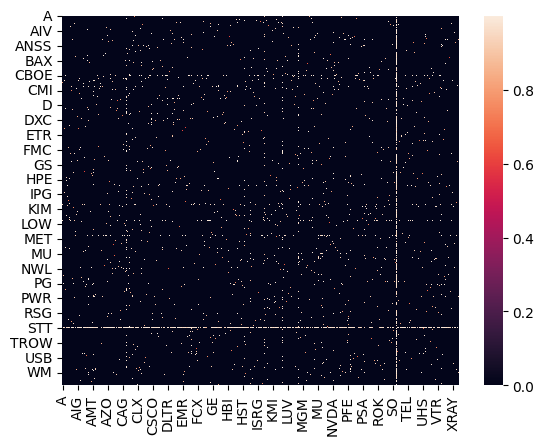

In [69]:
# Plot of the weight matrix after triangulated maximal filtering.
sns.heatmap(tmfg_df)

In [70]:
tmfg_G = initialize_graph(labels, tmfg_df)

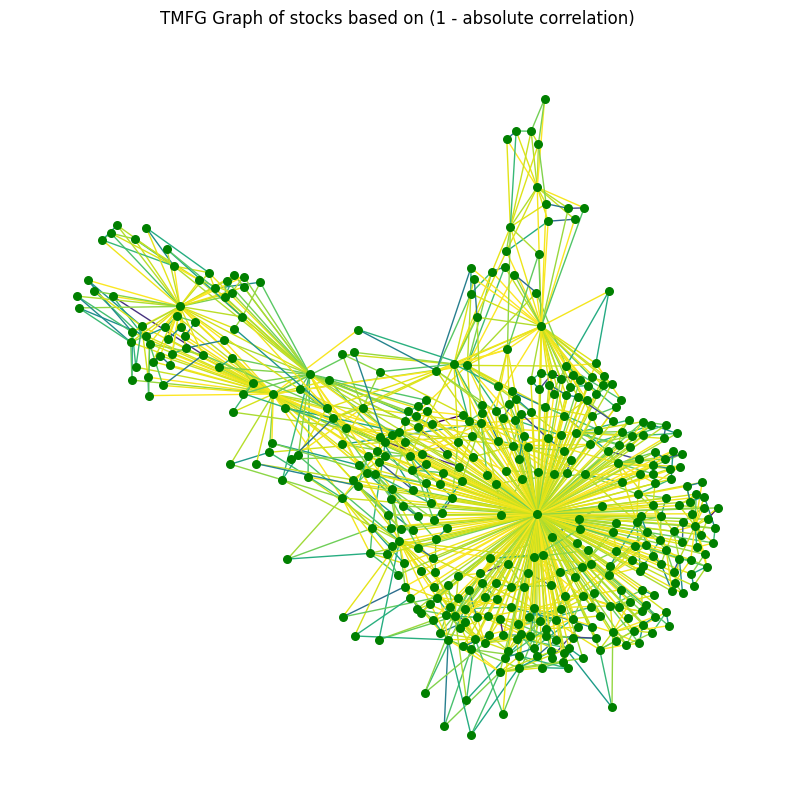

In [71]:
"""
Plot of TMFG
"""
fig,ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(tmfg_G, seed=42)
edge_weights = [d['weight'] for (_, _, d) in tmfg_G.edges(data=True)]

nx.draw(
    tmfg_G, 
    pos, 
    node_color='green', 
    edge_color=edge_weights, 
    width=1, 
    node_size=30, 
    edge_cmap=plt.cm.viridis
)
plt.title('TMFG Graph of stocks based on (1 - absolute correlation)')
plt.show()


## Portfolio Optimization Step

In [72]:
"""
Implementation of mean-variance optimal portfolio:

We assume the risk free rate to be the equal-weighted portfolio return.

min ((w^T * sigma^2 * w) - mu^T w)
s.t. 
sum(w) = 1 # sum of weights must be 1
w >= 0 # Long only
"""
mu = returns.to_numpy()
r = mu.mean()
excess = mu-r
sigma = covariance_matrix.to_numpy()
n = len(mu)

# Portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.dot(weights.T, np.dot(cov_matrix, weights))
    return returns, std

# Objective function
def objective(weights, mean_returns, cov_matrix):
    returns, std = portfolio_performance(weights, mean_returns, cov_matrix)
    return std-returns

# Constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(n))
init_guess = n * [1. / n,]

# Optimization
opt_result = minimize(objective, init_guess, args=(excess, sigma), bounds=bounds, constraints=constraints)

# Extract optimized weights
opt_weights = opt_result.x
opt_ret, opt_vol = portfolio_performance(opt_weights, excess, sigma)

print("Markowitz excess return: ",opt_ret)
print("Markowitz volatility: ", opt_vol)

Markowitz excess return:  1.851864000099703
Markowitz volatility:  0.0010572568105849287


To incorporate our graphs (MST, TMFG) into our optimization problem, we introduce C_n, a centrality measure.
The centrality measure serves as a way to quantify how far into the periphery of the graph a stock is.
So given the objective $\phi(x)$ to minimize and constraints described by the convex set $\mathcal{X}$, we have 
the following:

\begin{array}{rl}
\displaystyle \min_{x} & \phi(x) \\
\text{s.t.} & C_nx = \bar{c} \\
& x \in \mathcal{X}.
\end{array}

where $\bar{c}$ is the desired average centrality measure, and $x$ in our case is our portfolio weights.

The paper describes two methods:
1. Mixed Integer Programming
\begin{array}{rl}
\displaystyle \min_{x} & \phi(x) \\
\text{s.t.} & (B_{1,l}+I_n)y \leq 1 \\
& x_i \leq b_uy_i, \forall i\in {1,...,n}  \\
& x_i \geq b_ly_i, \forall i\in {1,...,n}  \\
& x \in \mathcal{X}.
\end{array}

where $y$ is a binary vector indicating if the asset is used, $(B_{1,l}+I_n)y \leq 1$ constrains the assets to be those not connected through walks of lengths less than or equal to $l$, $b_u$ and $b_l$ are upper and lower bounds of the weights of the assets.

2. Semidefinite Programming

\begin{array}{rl}
\displaystyle \min_{x,X} & Tr(\Sigma X) \\
\text{s.t.} & \begin{bmatrix} X & x \\ x^T & 1 \end{bmatrix} \succeq 0 \\\\
& X = X^T \\
& B_{1,l} \odot X = 0 \\
& x \in \mathcal{X}
\end{array}

where $X$ is a matrix approximating $xx^T$, $\Sigma$ is the covariance matrix, $\succeq 0$ indicates positive definiteness, and $\odot$ is the hadamard product. The constraint $B_{1,l} \odot X = 0$ ensures no assets are chosen that have a walk of length less than or equal to $l$, $X = X^T$ ensures $X$ is symmetric, and $x \in \mathcal{X}$ ensures the portfolio weights are within the convex set. The positive definiteness constraint ensures $X$ is at least as big as $xx^T$ and is a form of relaxation (making the problem easier to solve by 'relaxing' constraints).


In [73]:
"""
Functions to compute connection matrices B_k, B_{1,l}

B_k = (A^k + I_n) > 1
B_{1,l} = [sum_{1}^{k} (B_k)] > 1

"""

def connection_matrix(A : np.typing.NDArray[np.float64], k : int):
    """
    Args:
        A (np.typing.NDArray[np.float64]): adjacency matrix
        k (int): length of the walk
    """
    
    if len(A.shape) != 2:
        raise ValueError("Input must be a 2D array")
    if A.shape[0] != A.shape[1]:
        raise ValueError("Input must be a square matrix")
    n = A.shape[0]
    
    B_k = ((np.linalg.matrix_power(A,k) + np.identity(n))>1).astype(np.float64) - np.identity(n)
    
    return B_k

def connection_matrix_l(A : np.typing.NDArray[np.float64], l : int):
    """
    Args:
        A (np.typing.NDArray[np.float64]): adjacency matrix
        l (int): max length of the walk
    """
    if len(A.shape) != 2:
        raise ValueError("Input must be a 2D array")
    if A.shape[0] != A.shape[1]:
        raise ValueError("Input must be a square matrix")
    n = A.shape[0]

    B_1_l = np.zeros_like(A)
    for i in range(1,l+1):
        B_1_l += connection_matrix(A,i)
    B_1_l = (B_1_l>1).astype(np.float64)
    return B_1_l

In [74]:
adjacency_mst = (mst_weights>0).astype(np.float64)
adjacency_tmfg = (tmfg_weights>0).astype(np.float64)

In [78]:
"""
Mixed Integer Programming Approach
"""
def mixed_int_approach(adjacency, l, Sigma, excess, b_u=1, b_l=0):
    n = Sigma.shape[0]
    x = cp.Variable(n)
    y = cp.Variable(n, boolean=True)
    
    B = connection_matrix_l(adjacency,l)
    I_n = np.eye(B.shape[0])
    
    constraints =[
        (B+I_n) @ y <= 1,               # Walk constraint
        x <= b_u * y,                   # Upper bound weight
        x >= b_l * y,                   # Lower bound weight
        x >= 0,                         # Long-only constraint
        cp.sum(x) == 1                  # Weight constraint
    ]

    objective = cp.Minimize(cp.quad_form(x,cp.psd_wrap(Sigma)) - (x.T @ excess))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS_BB)
    
    weights = x.value
    return np.array(weights)


In [79]:
mst_mixed_int_weights = mixed_int_approach(adjacency_mst,3,covariance_matrix.to_numpy(), excess)
tmfg_mixed_int_weights = mixed_int_approach(adjacency_tmfg,3,covariance_matrix.to_numpy(), excess)

In [95]:
"""
Semi Definite Programming Approach
"""
def semi_def_approach(adjacency, l, Sigma):
    # Defining variables
    n = Sigma.shape[0]
    x = cp.Variable((n, 1))
    X = cp.Variable((n, n), symmetric=True)
    Z = cp.bmat([
        [X, x],
        [x.T, cp.Constant([[1]])]
    ])

    B = connection_matrix_l(adjacency,l)

    constraints = [
        Z >> 0,                         # Positive definite constraint
        cp.multiply(B, X) == 0,         # Hadamard constraint
        x >= 0,                         # Long-only constraint
        cp.sum(x) == 1                  # Weight constraint
    ]

    objective = cp.Minimize(cp.trace(Sigma @ X))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    weights = x.value
    return np.array(weights).flatten()

In [96]:
mst_semi_def_weights = semi_def_approach(adjacency_mst,3,covariance_matrix.to_numpy())
tmfg_semi_def_weights = semi_def_approach(adjacency_tmfg,3,covariance_matrix.to_numpy())

c:\Users\Conrad\Documents\GitHub\Imperial-Portfolio-Theory-DRP\venv\Lib\site-packages\cvxpy\expressions\constants\constant.py:52: UserWarning: Initializing a Constant with a nested list is undefined behavior. Consider using a numpy array instead.
  warnings.warn(NESTED_LIST_WARNING)


## Results in-sample vs out-of-sample data

In [108]:
"""
We use a measure close to the Sharpe ratio to score portfolio performance:
    excess_returns/variance
The reason this is only close is because we've used log returns
"""

mu = returns.to_numpy()
r = mu.mean()
in_sample_excess = mu-r
in_sample_sigma = covariance_matrix.to_numpy()

mu = out_of_sample_returns.to_numpy()
r = mu.mean()
out_sample_excess = mu-r
out_sample_sigma = out_of_sample_covariance_matrix.to_numpy()

models = {
"markowitz" : opt_weights,
"MST MIP" : mst_mixed_int_weights,
"MST SDP" : mst_semi_def_weights,
"TMFG MIP" : tmfg_mixed_int_weights,
"TMFG SDP" : tmfg_semi_def_weights 
}

in_sample_results = dict()
out_sample_results = dict()


for model_name, weights in models.items():
    portfolio_returns, variance = portfolio_performance(weights,in_sample_excess,in_sample_sigma)
    in_sample_results[model_name] = portfolio_returns/variance   
    portfolio_returns, variance = portfolio_performance(weights,out_sample_excess,out_sample_sigma)
    out_sample_results[model_name] = portfolio_returns/variance

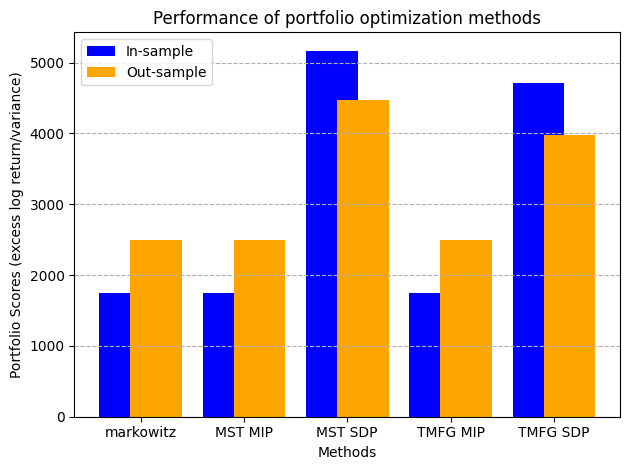

In [113]:
labels = list(in_sample_results.keys())
in_sample_scores = list(in_sample_results.values())
out_sample_scores = list(out_sample_results.values())
x = np.arange(len(labels))

width = 0.3
width_bar = 0.5
# plt.figure(figsize=(8, 5))
plt.bar(x-width/2, in_sample_scores, width_bar, color='blue', label = "In-sample")
plt.bar(x+width/2, out_sample_scores, width_bar, color='orange', label = "Out-sample")

plt.xlabel("Methods")
plt.xticks(x, labels)
plt.ylabel("Portfolio Scores (excess log return/variance)")
plt.title("Performance of portfolio optimization methods")

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.legend()

## Closing remarks:
From the above chart, we see that in both in-sample and out-of-sample performance, the semi-definite programming approach outperforms the traditional markowitz model, implying an edge to be had in using graph centrality measures.